In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_rows", 1000)

# Загрузка данных

In [3]:
sales_train = pd.read_csv('../data/sales_train.csv.gz')
test = pd.read_csv('../data/test.csv.gz')
items = pd.read_csv('../data/items.csv')
item_categories = pd.read_csv('../data/item_categories.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
shops = pd.read_csv('../data/shops.csv')

# Обзор данных

## Магазины

In [4]:
shops.shape

(60, 2)

In [5]:
shops.head(20)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Сразу видно, что разные магазины находятся в разных зданиях: где-то это ТЦ/ТРЦ, где-то это просто жилой дом, где-то еще тип не указан. Это наталкивает на мысль, что привязанность к тому или иному объекту градостроения может влиять на продажи. Значит, если эти признаки посмотреть подробнее, можно сделать интересные признаки.

Добавим признак `is_mall`, сигнализирующий, что данный магазин находится в ТЦ/ТРЦ/ТК/ТРК:

In [6]:
shops['is_mall'] = ((shops['shop_name'].str.find('ТЦ') != -1) | \
                     (shops['shop_name'].str.find('ТРЦ') != -1) | \
                     (shops['shop_name'].str.find('ТК') != -1) | \
                     (shops['shop_name'].str.find('ТРК') != -1)).astype(int)

А теперь посмотрим на те магазины, к которым данный признак не добавился.

In [7]:
shops[shops['is_mall'] == 0].sort_values('shop_name')

,shop_name,shop_id,is_mall
0,"!Якутск Орджоникидзе, 56 фран",0,0
6,"Воронеж (Плехановская, 13)",6,0
9,Выездная Торговля,9,0
10,Жуковский ул. Чкалова 39м?,10,0
11,Жуковский ул. Чкалова 39м²,11,0
12,Интернет-магазин ЧС,12,0
20,"Москва ""Распродажа""",20,0
22,Москва Магазин С21,22,0
55,Цифровой склад 1С-Онлайн,55,0
57,"Якутск Орджоникидзе, 56",57,0


Может показаться, что некоторые магазины дублируют друг друга, однако дополнительная проверка по суммарным объемам продаж это не подтверждает. Сама проверка ради краткости здесь не приведена.

Также проверим, все ли магазины из обучающей выборки приведены в тестовой выборке.

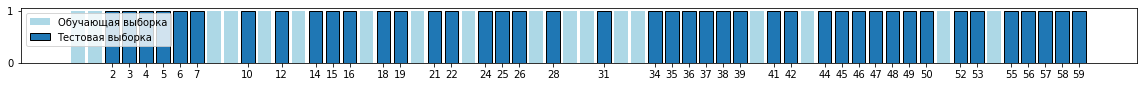

In [8]:
train_shops = np.sort(sales_train['shop_id'].unique())
test_shops = np.sort(test['shop_id'].unique())
fig = plt.figure(figsize=(20, 1))
plt.bar(train_shops, np.ones(len(train_shops)), color='lightblue')
plt.bar(test_shops, np.ones(len(test_shops)), edgecolor='black')
plt.xticks(test_shops)
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.show()

Очевидно, что не все магазины обучающей выборки содержатся в тестовой. Если вспомнить, что для тестовых данных надо предсказывать продажи конкретных видов товаров по конкретным магазинам, то при построении модели будет иметь смысл проверять точность прогнозов по тем магазинам, которые есть и в обучающей и в тестовой выборке. Посчитаем число этих магазинов.

In [9]:
print(f'Число магазинов в обучающей выборке - {len(train_shops)}\nЧисло магазинов в тестовой выборке - {len(test_shops)}')

Число магазинов в обучающей выборке - 60
Число магазинов в тестовой выборке - 42


Проверим, что все магазины тестовой выборки есть в обучающей.

In [10]:
test_shops[~np.isin(test_shops, train_shops)]

array([], dtype=int64)

Из названия магазина очевидно его местонахождение: это может быть какой-то город, интернет-магазин, цифровой склад и т.д. Город может оказаться нужным признаком особенно, если мы будем знать его население.

In [11]:
location = ['Якутск', 'Якутск', 'Краснодар', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Воронеж', 'Воронеж', \
            'Выездная Торговля', 'Жуковский', 'Жуковский', 'Интернет-Магазин', 'Казань', 'Казань', 'Калуга', \
            'Коломна', 'Красноярск', 'Красноярск', 'Курск', 'Москва', 'Москва', 'Москва', 'Москва', 'Москва', \
            'Москва', 'Москва', 'Москва', 'Москва', 'Москва', 'Москва', 'Москва', 'Москва', 'Мытищи', 'Нижний Новгород',\
            'Нижний Новгород', 'Новосибирск', 'Новосибирск', 'Омск', 'Ростов-на-Дону', 'Ростов-на-Дону', 'Ростов-на-Дону',\
            'Санкт-Петербург', 'Санкт-Петербург', 'Самара', 'Самара', 'Сергиев Посад', 'Сургут', 'Томск', 'Тюмень', \
            'Тюмень', 'Тюмень', 'Уфа', 'Уфа', 'Химки', 'Цифровой склад', 'Чехов', 'Якутск', 'Якутск', 'Ярославль']
shops['location'] = location

In [12]:
city = ['Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Жуковский', 'Казань', 'Калуга', 'Коломна', \
        'Краснодар', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Нижний Новгород', 'Новосибирск', \
        'Омск', 'Ростов-на-Дону', 'Самара', 'Санкт-Петербург', 'Сергиев Посад', 'Сургут', 'Томск', \
        'Тюмень', 'Уфа', 'Химки', 'Чехов', 'Якутск', 'Ярославль']
population_2013 = [235336, 327356, 306487, 1003638, 106872, 1176187, 331351, 144707, 784048, 1016385, 428741, 11979529, 178672, 1259921, 1523801, 1160670, 1103733, 1171598, 5028000, 108490, 325511, 547989, 634171, 1077719, 221084, 65359, 286456, 599169]
population_2014 = [247075, 326841, 308172, 1014610, 107552, 1190850, 334191, 144316, 805680, 1035528, 431171, 12108257, 183224, 1263873, 1547910, 1166092, 1109835, 1172348, 5131942, 106718, 332313, 557179, 679861, 1096702, 225678, 67603, 294138, 602400]
population_2015 = [260704, 326602, 311166, 1023570, 107815, 1205651, 342936, 144253, 829677, 1052218, 435117, 12197596, 187119, 1267760, 1567087, 1173854, 1114806, 1171820, 5191690, 106007, 340845, 564910, 697037, 1105667, 232066, 69028, 299169, 603961]
cities = pd.DataFrame({'city': city, '2013': population_2013, '2014': population_2014, '2015': population_2015})

In [13]:
shops_enriched = pd.merge(shops, cities, left_on='location', right_on='city', how='left')
shops_enriched = shops_enriched.drop(columns='city').fillna(0)
shops_enriched.head()

,shop_name,shop_id,is_mall,location,2013,2014,2015
0,"!Якутск Орджоникидзе, 56 фран",0,0,Якутск,286456.0,294138.0,299169.0
1,"!Якутск ТЦ ""Центральный"" фран",1,1,Якутск,286456.0,294138.0,299169.0
2,"Адыгея ТЦ ""Мега""",2,1,Краснодар,784048.0,805680.0,829677.0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1,Балашиха,235336.0,247075.0,260704.0
4,"Волжский ТЦ ""Волга Молл""",4,1,Волжский,327356.0,326841.0,326602.0


In [40]:
shops_enriched.to_csv('../data/shops_enriched.csv', index=False)

## Категории товаров

In [15]:
item_categories.shape

(84, 2)

Здесь видно, что почти каждая категория по сути содержит в себе название категорий двух уровней. Причем от записи к записи могут повторяться названия обеих категорий - уникальными бывают только их комбинации. Это наводит на мысль добавить в качестве признака mean-encoding по каждому из уровней.

Пока сделаем следующее: разделим признак `item_category_name` на два признака: `cat_1` и `cat_2`. Делить будем по следующему правилу:
1. Если в названии признака есть хотя-бы один дефис, то текст перед первым дефисом будет icm1, a текст после него - icm2.
2. Если на названии признака дефиса нет, то относим все содержимое к icm1.

In [16]:
item_categories['cat_1'] = item_categories['item_category_name'].str.extract('(^[^-]*[^ -])')
item_categories['cat_2'] = item_categories['item_category_name'].str.replace('(^[^-]*[^ -])', '').str.strip(to_strip=' ').str.strip(to_strip='-')
item_categories.head()

,item_category_name,item_category_id,cat_1,cat_2
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [41]:
item_categories.to_csv('../data/item_categories_enriched.csv', index=False)

## Товары

In [18]:
items.shape

(22170, 3)

In [19]:
pd.merge(items, item_categories, how='outer', on='item_category_id').head(20)

,item_name,item_id,item_category_id,item_category_name,cat_1,cat_2
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD
5,***УДАР ПО ВОРОТАМ (UNI) D,6,40,Кино - DVD,Кино,DVD
6,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40,Кино - DVD,Кино,DVD
7,***ЧАЙ С МУССОЛИНИ D,8,40,Кино - DVD,Кино,DVD
8,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40,Кино - DVD,Кино,DVD
9,*ЗА ГРАНЬЮ СМЕРТИ D,10,40,Кино - DVD,Кино,DVD


Здесь особых мыслей не приходит. Разве что, собрать жанры фильмов, игр и книг и вынести их в отдельный признак. Но это долго. Можно еще посмотреть присутствие товаров обучающей выборки в тестовой.

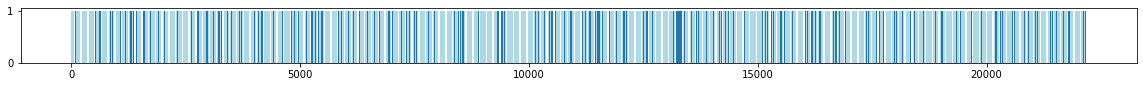

In [20]:
train_items = np.sort(sales_train['item_id'].unique())
test_items = np.sort(test['item_id'].unique())
fig = plt.figure(figsize=(20, 1))
plt.bar(train_items, np.ones(len(train_items)), color='lightblue')
plt.bar(test_items, np.ones(len(test_items)))
plt.show()

Здесь также очевидно, что не все товары обучающей выборки есть в тестовой. И, как и в случае с магазинами, не надо предсказывать продажи по всем видам товаров. Посчитаем число товаров в обучающей и тестовой выборках.

In [21]:
print(f'Число товаров в обучающей выборке - {len(train_items)}\nЧисло товаров в тестовой выборке - {len(test_items)}')

Число товаров в обучающей выборке - 21807
Число товаров в тестовой выборке - 5100


Проверим, что все товары тестовой выборки есть в обучающей.

In [22]:
a = np.array([1, 2, 3, 4, 5, 6])
b = np.array([3, 4, 5, 6])
print(b[~np.isin(b, a)])
print(a[~np.isin(a, b)])
print(len(a[~np.isin(a, b)]))

[]
[1 2]
2


In [23]:
missing_items = test_items[~np.isin(test_items, train_items)]
len(missing_items)

363

Не все. И это проблема, т.к. получается, что продажи 363 товаров в будущем мы не можем смоделировать на основании их истории продаж. Посмотрим, что это за товары.

In [24]:
items[items['item_id'].isin(missing_items)]

,item_name,item_id,item_category_id
83,12/ДВЕНАДЦАТЬ (СР) (Регион),83,40
140,1С:Аудиокниги. Аладдин и другие восточные сказ...,140,45
168,1С:Аудиокниги. Аудиокурсы по географии. 6 клас...,168,44
173,1С:Аудиокниги. Аудиоэнциклопедия для самых мал...,173,45
204,"1С:Аудиокниги. Г.Р. Хаггард. Клеопатра [PC, Ци...",204,44
237,"1С:Аудиокниги. Для самых маленьких. Сказки, по...",237,45
249,1С:Аудиокниги. Жюль Верн. Пятнадцатилетний кап...,249,45
254,1С:Аудиокниги. Илья Ильин. Если бы я был робин...,254,44
302,1С:Аудиокниги. Лопатина И. Крапиты. Часть 1,302,45
402,1С:Аудиокниги. Чарская Л. А. Сказки голубой фе...,402,44


Посмотрим на распределение категорий этих отсутствующих товаров

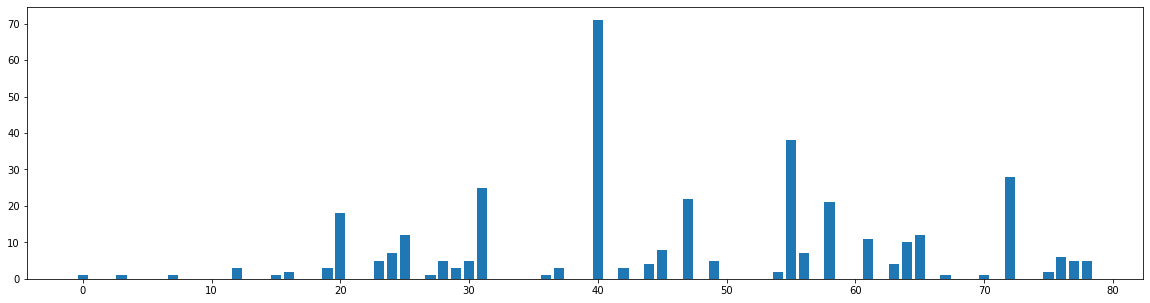

In [25]:
missing_item_categories = items[items['item_id'].isin(missing_items)].groupby('item_category_id')['item_id'].count()
fig = plt.figure(figsize=(20, 5))
plt.bar(missing_item_categories.index, missing_item_categories.values)
plt.show()

Посмотрим на названия топ-15 категорий отсутствующих товаров

In [26]:
item_categories[item_categories['item_category_id'].isin(missing_item_categories.sort_values(ascending=False).iloc[0:17])]

,item_category_name,item_category_id,cat_1,cat_2
5,Аксессуары - PSVita,5,Аксессуары,PSVita
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE
8,Билеты (Цифра),8,Билеты (Цифра),
10,Игровые консоли - PS2,10,Игровые консоли,PS2
11,Игровые консоли - PS3,11,Игровые консоли,PS3
12,Игровые консоли - PS4,12,Игровые консоли,PS4
18,Игры - PS2,18,Игры,PS2
21,Игры - PSP,21,Игры,PSP
22,Игры - PSVita,22,Игры,PSVita


То есть, нам надо спрогнозировать число проданных товаров, данные о предыдущих продажах которых отсутствуют.

На ум приходит простой вариант работы с этими отсутствующими товарами:

1) Считаем средний прогноз продаж на ноябрь 2015 для товаров данной категории  
2) Берем его в качестве прогноза по продажам данного товара  

Но этот алгоритм делает одно важное допущение: все категории товаров тестовой выборки должны присутствовать в обучающей выборке. Проверим это допущение.

In [27]:
train_item_categories = items[items['item_id'].isin(train_items)]['item_category_id'].unique()
test_item_categories = items[items['item_id'].isin(test_items)]['item_category_id'].unique()
test_item_categories[~np.isin(test_item_categories, train_item_categories)]

array([], dtype=int64)

К счастью оно подтвердилось.

In [28]:
sample_submission

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


## Транзакции

In [29]:
sales_train.shape

(2935849, 6)

In [30]:
sales_train_enriched = sales_train.copy()
sales_train_enriched

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


Первое, что здесь приходит на ум - это проверить, все ли даты за период с января 2013 по октябрь 2015 включительно представлены. Но, если представлены не все даты, то придется как-то заполнять пустоты для продаж каждого товара в каждом магазине за каждую пропущенную дату. Это во-первых долго, а во-вторых, сильно раздувает исходные данные. По этой причине просто проверим даты.

In [31]:
dates_presented = pd.to_datetime(sales_train_enriched['date'].unique())
dates_presented = dates_presented.sort_values()
dates_full = pd.date_range(dates_presented.min(), dates_presented.max())
dates_missing = dates_full[~dates_full.isin(dates_presented)]
print(f'{dates_missing}\nВсего пропущенных дат {len(dates_missing)}')

DatetimeIndex(['2015-01-11', '2015-01-12', '2015-02-11', '2015-02-12',
               '2015-03-11', '2015-03-12', '2015-04-11', '2015-04-12',
               '2015-05-11', '2015-05-12', '2015-06-11', '2015-06-12',
               '2015-07-11', '2015-07-12', '2015-08-11', '2015-08-12',
               '2015-09-11', '2015-09-12', '2015-10-11', '2015-10-12',
               '2015-11-11', '2015-11-12', '2015-11-13', '2015-11-14',
               '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
               '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22',
               '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
               '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30'],
              dtype='datetime64[ns]', freq=None)
Всего пропущенных дат 40


То есть, в 2015 году во-первых пропущены 11 и 12 числа каждого месяца, а во-вторых с 1 по 10 ноября есть данные как минимум по некоторым магазинам. Это наталкивает на мысль, что если будем прогнозировать сначала продажи на конкретные даты, то можно откорректировать ноябрьские данные итоговой модели исходя из фактических продаж в ноябре.

Еще здесь приходит на ум обработка дат: выходные/будни/праздники. Плюс еще, конечно хочется посмотреть графики продаж товаров по типам и по магазинам. Также на ум приходит собрать в отдельные признаки продажи за последние 30, 60, 90 и т.д. дней. Сбор продаж за прошлые периоды отложим на попозже, т.к. это снова долго и раздувает данные.

Для этого сначала преобразуем поле date в тип дата/время. Помним, что в результате будет понедельник = 0, а воскресенье = 6.

In [32]:
sales_train_enriched['date'] = pd.to_datetime(sales_train_enriched['date'])
sales_train_enriched['dayofweek'] = sales_train_enriched['date'].dt.dayofweek
sales_train_enriched.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek
0,2013-02-01,0,59,22154,999.00,1.0,4
1,2013-03-01,0,25,2552,899.00,1.0,4
2,2013-05-01,0,25,2552,899.00,-1.0,2
3,2013-06-01,0,25,2554,1709.05,1.0,5
4,2013-01-15,0,25,2555,1099.00,1.0,1


Теперь проставим рабочие дни и выходные, не обращая внимания на трудовой календарь. То есть, рабочие - это все дни с понедельника по пятницу, а выходные - суббота и воскресенье.

In [33]:
sales_train_enriched.loc[sales_train_enriched['dayofweek'].isin(range(0, 5)), 'daytype'] = 'WorkDay'
sales_train_enriched.loc[sales_train_enriched['dayofweek'].isin(range(5, 7)), 'daytype'] = 'Weekend'
sales_train_enriched

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,daytype
0,2013-02-01,0,59,22154,999.00,1.0,4,WorkDay
1,2013-03-01,0,25,2552,899.00,1.0,4,WorkDay
2,2013-05-01,0,25,2552,899.00,-1.0,2,WorkDay
3,2013-06-01,0,25,2554,1709.05,1.0,5,Weekend
4,2013-01-15,0,25,2555,1099.00,1.0,1,WorkDay
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,5,Weekend
2935845,2015-09-10,33,25,7460,299.00,1.0,3,WorkDay
2935846,2015-10-14,33,25,7459,349.00,1.0,2,WorkDay
2935847,2015-10-22,33,25,7440,299.00,1.0,3,WorkDay


Обозначим праздники за 2013-2015 годы и рабочие субботы-воскресенья. Помним, что люди ходят за подарками не только в праздники, но и перед ними. Также после праздников посещаемость может отличаться от обычной. Поэтому еще обозначаем даты за 1-3 дня до праздников и 1-3 дня после праздников.

In [74]:
pub_hol = pd.DataFrame(columns=['date', 'daytype'])
#2013
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-01-01', 'D') + np.arange(8), 'daytype': 'NewYear'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-03-08', 'D') + np.arange(1), 'daytype': 'WomenDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-05-01', 'D') + np.arange(3), 'daytype': 'LabourDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-05-09', 'D') + np.arange(2), 'daytype': 'VictoryDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-06-12', 'D') + np.arange(1), 'daytype': 'RussiaDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-11-04', 'D') + np.arange(1), 'daytype': 'PolandDay'}))
#pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2013-12-30', 'D') + np.arange(1), 'daytype': 'WorkDay'}))
#2014
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-01-01', 'D') + np.arange(8), 'daytype': 'NewYear'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-03-10', 'D') + np.arange(1), 'daytype': 'WomenDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-05-01', 'D') + np.arange(2), 'daytype': 'LabourDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-05-09', 'D') + np.arange(1), 'daytype': 'VictoryDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-06-12', 'D') + np.arange(2), 'daytype': 'RussiaDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2014-11-03', 'D') + np.arange(2), 'daytype': 'PolandDay'}))
#2015
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-01-01', 'D') + np.arange(11), 'daytype': 'NewYear'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-02-23', 'D') + np.arange(1), 'daytype': 'MenDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-03-09', 'D') + np.arange(1), 'daytype': 'WomenDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-05-01', 'D') + np.arange(4), 'daytype': 'LabourDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-05-09', 'D') + np.arange(3), 'daytype': 'VictoryDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-06-12', 'D') + np.arange(1), 'daytype': 'RussiaDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-11-04', 'D') + np.arange(1), 'daytype': 'PolandDay'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-12-29', 'D') + np.arange(1), 'daytype': 'NewYearMinus3'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-12-30', 'D') + np.arange(1), 'daytype': 'NewYearMinus2'}))
pub_hol = pub_hol.append(pd.DataFrame({'date': np.datetime64('2015-12-31', 'D') + np.arange(1), 'daytype': 'NewYearMinus1'}))

pub_hol_first_last_day = pub_hol.copy()
pub_hol_first_last_day = pub_hol_first_last_day[~pub_hol_first_last_day['daytype'].str.contains('Minus') &\
                                                ~pub_hol_first_last_day['daytype'].str.contains('Plus')]
pub_hol_first_last_day['year'] = pd.DatetimeIndex(pub_hol_first_last_day['date']).year
pub_hol_first_day = pd.DataFrame(pub_hol_first_last_day.groupby(['daytype', 'year'])['date'].min()).reset_index()
pub_hol_last_day = pd.DataFrame(pub_hol_first_last_day.groupby(['daytype', 'year'])['date'].max()).reset_index()

for i in list(range(1, 1 + 3)):
    pub_hol_before = pd.DataFrame(columns=['date', 'daytype'])
    pub_hol_before['date'] = pub_hol_first_day['date'] - np.timedelta64(i, 'D')
    pub_hol_before['daytype'] = pub_hol_first_day['daytype'] + f'Minus{i}'
    pub_hol_before = pub_hol_before[~np.isin(pub_hol_before['date'], pub_hol['date'])]
    pub_hol = pub_hol.append(pub_hol_before)
    
for i in list(range(1, 1 + 3)):
    pub_hol_after = pd.DataFrame(columns=['date', 'daytype'])
    pub_hol_after['date'] = pub_hol_last_day['date'] + np.timedelta64(i, 'D')
    pub_hol_after['daytype'] = pub_hol_last_day['daytype'] + f'Plus{i}'
    pub_hol_after = pub_hol_after[~np.isin(pub_hol_after['date'], pub_hol['date'])]
    pub_hol = pub_hol.append(pub_hol_after)
    
pub_hol = pub_hol.sort_values('date').reset_index(drop=True)

In [75]:
for date_val in pub_hol['date'].values:
    sales_train_enriched.loc[sales_train_enriched['date'] == date_val, 'daytype'] = pub_hol.loc[pub_hol['date'] == date_val, 'daytype'].values[0]

In [76]:
sales_train_enriched.sort_values(['date'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,daytype
109593,2013-01-01,0,46,18616,349.0,1.0,1,NewYear
85162,2013-01-01,0,54,11854,199.0,1.0,1,NewYear
18128,2013-01-01,0,28,4906,1799.0,1.0,1,NewYear
112216,2013-01-01,0,42,2931,99.0,1.0,1,NewYear
85141,2013-01-01,0,54,11604,349.0,1.0,1,NewYear
...,...,...,...,...,...,...,...,...
2915898,2015-12-10,33,6,7390,349.0,1.0,3,WorkDay
2915896,2015-12-10,33,6,7350,349.0,1.0,3,WorkDay
2922604,2015-12-10,33,28,10304,199.0,1.0,3,WorkDay
2915871,2015-12-10,33,6,6798,1849.0,1.0,3,WorkDay


In [77]:
sales_train_enriched.to_csv('../data/sales_train_enriched.csv.gz', index=False, compression='gzip')

Еще надо отметить, что у нас получился неплохой трудовой календарь на 3 года. Его можно сохранить в отдельном файле.

In [97]:
labour_calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2015-12-31'))
labour_calendar['dayofweek'] = labour_calendar.index.dayofweek
labour_calendar.loc[labour_calendar['dayofweek'].isin(range(0, 5)), 'daytype'] = 'WorkDay'
labour_calendar.loc[labour_calendar['dayofweek'].isin(range(5, 7)), 'daytype'] = 'Weekend'
labour_calendar = labour_calendar.merge(pub_hol, how='left', left_index=True, right_on='date')
labour_calendar.loc[~labour_calendar['daytype_y'].isnull(), 'daytype_x'] = \
    labour_calendar.loc[~labour_calendar['daytype_y'].isnull(), 'daytype_y']
labour_calendar = pd.DataFrame(index=pd.DatetimeIndex(labour_calendar['date']), \
             data={'dayofweek': labour_calendar['dayofweek'].values, 'daytype': labour_calendar['daytype_x'].values})
labour_calendar.to_csv('../data/labour_calendar.csv')
labour_calendar.head(15)

,dayofweek,daytype
date,,
2013-01-01,1,NewYear
2013-01-02,2,NewYear
2013-01-03,3,NewYear
2013-01-04,4,NewYear
2013-01-05,5,NewYear
2013-01-06,6,NewYear
2013-01-07,0,NewYear
2013-01-08,1,NewYear
2013-01-09,2,NewYearPlus1
